In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import random
import warnings

warnings.filterwarnings("ignore")

# Check if CUDA is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
class ChromaDataset(Dataset):
    """
    Includes functionality to take a pair of perfonmances, load their feauters,
    downsample, normalise them in preparation for the Siamese network.
    """

    def __init__(self, pairs_list, target_length=2000):
        self.pairs_list = pairs_list
        self.target_length = target_length

    def __len__(self):
        return len(self.pairs_list)

    def load_features(self, h5_path):
        """
        Load chromagram features from H5 file and preprocess them.
        """
        with h5py.File(h5_path, "r") as f:
            features = np.array(f["crema"], dtype=np.float32)

            # normalize features
            row_norms = np.sqrt(np.sum(features**2, axis=1, keepdims=True))
            features = np.divide(features, row_norms, where=row_norms > 1e-10)

            # downsample 
            if len(features) > self.target_length:
                downsample_factor = len(features) // self.target_length
                features = features[::downsample_factor]

            # trim or pad to target_length
            if len(features) > self.target_length:
                features = features[: self.target_length]
            elif len(features) < self.target_length:
                pad_width = ((0, self.target_length - len(features)), (0, 0))
                features = np.pad(features, pad_width, mode="constant")

            # convert to torch tensor
            return torch.tensor(features, dtype=torch.float32)

    def __getitem__(self, idx):
        # get features
        path1, path2, label = self.pairs_list[idx]
        features1 = self.load_features(path1)
        features2 = self.load_features(path2)

        return {"chroma1": features1, "chroma2": features2, "label": torch.tensor(label, dtype=torch.float32), "path1": path1, "path2": path2}

In [3]:
def generate_pairs(base_folder, num_positive=1000, num_negative=1000, max_files_per_work=5):
    """
    Generate pairs of songs for training the Siamese network.
    Select number of positive and negative pairs.
    """
    base_path = Path(base_folder)
    work_folders = [d for d in base_path.iterdir() if d.is_dir()]
    pairs = []

    # Generate positive pairs (pairs from same work)
    positive_count = 0
    print("Generating positive pairs...")

    for work_folder in work_folders :
        if positive_count >= num_positive:
            break

        h5_files = list(work_folder.glob("*.h5"))
        if len(h5_files) > max_files_per_work:  # sample a subset if needed
            h5_files = random.sample(h5_files, max_files_per_work)
        elif len(h5_files) < 2: # skip if there are less than 2 performances
            continue

        for i in range(len(h5_files)):
            for j in range(i + 1, len(h5_files)):
                pairs.append((str(h5_files[i]), str(h5_files[j]), 1))  # Label 1 for positive pairs
                positive_count += 1

                if positive_count >= num_positive:
                    break
            if positive_count >= num_positive:
                break

    # Generate negative pairs (pairs from different works)
    negative_count = 0
    print("Generating negative pairs...")

    while negative_count < num_negative:
        # select two different works
        work1, work2 = random.sample(work_folders, 2)

        # get performances
        h5_files1 = list(work1.glob("*.h5"))
        h5_files2 = list(work2.glob("*.h5"))
        if not h5_files1 or not h5_files2: #skip if work is empty
            continue

        # sample one performance from each work
        file1 = random.choice(h5_files1)
        file2 = random.choice(h5_files2)

        pairs.append((str(file1), str(file2), 0))  # Label 0 for negative pairs
        negative_count += 1

    print("Shuffle pairs...")
    random.shuffle(pairs)

    return pairs

In [4]:
#Siamese network creation. Two identical small CNNs and a custom loss function

class ConvBlock(nn.Module):
    """
    convolutional block with batch normalization and dropout.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout=0.2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout) 

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.dropout(x)
        return x


class FeatureExtractor(nn.Module):
    """
    CNN network that works as a feature extractor for the chromagrams
    Converts the sequence into an embedding using convolutional layers and pooling.
    """

    def __init__(self, input_dims=12, embedding_size=128):
        super(FeatureExtractor, self).__init__()

        self.conv_layers = nn.Sequential(
            ConvBlock(input_dims, 32),
            nn.MaxPool1d(kernel_size=4, stride=4),
            ConvBlock(32, 64),
            nn.MaxPool1d(kernel_size=4, stride=4),
            ConvBlock(64, 128),
            nn.MaxPool1d(kernel_size=4, stride=4),
            ConvBlock(128, 256),
            nn.MaxPool1d(kernel_size=4, stride=4),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1) # average pooling
        self.global_max_pool = nn.AdaptiveMaxPool1d(1) # max pooling

        # dense layer
        self.fc_layers = nn.Sequential(nn.Linear(256 * 2, 512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, embedding_size))  # *2 because we concatenate avg and max pool

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv_layers(x)
        # apply pooling
        avg_pool = self.global_avg_pool(x).squeeze(-1)
        max_pool = self.global_max_pool(x).squeeze(-1)
        # concatenate pooling results
        x = torch.cat((avg_pool, max_pool), dim=1)
        # generate embedding after dense and normalisation 
        embedding = self.fc_layers(x)
        embedding = F.normalize(embedding, p=2, dim=1)

        return embedding


class SiameseNet(nn.Module):
    def __init__(self, embedding_size=128):
        super(SiameseNet, self).__init__()

        # delcare feature extractor type
        self.feature_extractor = FeatureExtractor(embedding_size=embedding_size)

        # Final dense layers
        self.final_fc = nn.Sequential(nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 1), nn.Sigmoid())

    def forward(self, x1, x2):
        #process embeddings
        embedding1 = self.feature_extractor(x1)
        embedding2 = self.feature_extractor(x2)

        # Compute distance 
        squared_diff = (embedding1 - embedding2) ** 2
        squared_distance = torch.sum(squared_diff, dim=1, keepdim=True) + 1e-8
        distance = torch.sqrt(squared_distance)

        # learn similarity from distance
        similarity = self.final_fc(distance)

        return similarity, embedding1, embedding2, distance


class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function for Siamese networks.
    Encourages similar pairs to have small distances and
    dissimilar pairs to have distances larger than a margin.
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distance, y):

        # distance = euclidean distance between embeddings
        # y = 1 if same work, 0 if different works

        # loss for similar pairs: distance^2
        similar_loss = y * torch.pow(distance, 2)

        # loss for dissimilar pairs: max(0, margin - distance)^2
        dissimilar_loss = (1 - y) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)

        # mean loss across the batch
        loss = torch.mean(similar_loss + dissimilar_loss) / 2.0

        return loss

In [5]:
# def evaluate(model, data_loader, loss_function, device):
#     """
#     Evaluate the model on validation data.

#     Args:
#         model: The Siamese network
#         data_loader: DataLoader for validation data
#         loss_function: Loss function
#         device: Device to evaluate on (GPU/CPU)

#     Returns:
#         Average loss, predictions, true labels, distances
#     """
#     model.eval()
#     running_loss = 0.0
#     all_preds = []
#     all_labels = []
#     all_distances = []

#     with torch.no_grad():
#         for batch in tqdm(data_loader, desc="Evaluating"):
#             # Move data to device
#             chroma1 = batch["chroma1"].to(device)
#             chroma2 = batch["chroma2"].to(device)
#             labels = batch["label"].to(device)

#             # Forward pass
#             preds, _, _, distances = model(chroma1, chroma2)

#             # Compute loss
#             loss = loss_function(distances, labels.view(-1, 1))

#             running_loss += loss.item()

#             # Store predictions and labels
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             all_distances.extend(distances.cpu().numpy())

#     return running_loss / len(data_loader), np.array(all_preds), np.array(all_labels), np.array(all_distances)

In [6]:
# Create visualization directory
viz_folder = Path("visualization_results_siamese")
viz_folder.mkdir(exist_ok=True)

In [7]:
def plot_metrics(distances, labels, threshold=0.5):
    """
    Plot distances distribution
    Plot ROC_AUC and Precision_Recall curves for model evaluation.
    """
    distances = distances.flatten()
    labels = labels.flatten()

    precision, recall, pr_thresholds = precision_recall_curve(labels, 1 - distances)

    fpr, tpr, roc_thresholds = roc_curve(labels, 1 - distances)
    roc_auc = auc(fpr, tpr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Precision-Recall curve
    ax1.plot(recall, precision, lw=2)
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    ax1.set_title("Precision-Recall Curve")
    ax1.grid(True)

    # ROC curve
    ax2.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    ax2.plot([0, 1], [0, 1], "k--", lw=2)
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="lower right")
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(viz_folder / "training_metrics.png")
    plt.close()

    # Plot distance distributions
    plt.figure(figsize=(10, 6))
    plt.hist(distances[labels == 1], bins=30, alpha=0.5, label="Same Work (Cover)")
    plt.hist(distances[labels == 0], bins=30, alpha=0.5, label="Different Works (Not Cover)")
    plt.axvline(x=threshold, color="r", linestyle="--", label=f"Basic Threshold ({threshold:.2f})")
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.title("Distribution of Distances on training set")
    plt.legend()
    plt.grid(True)
    plt.savefig(viz_folder / "training_distance_distribution.png")
    plt.close()

In [8]:
def setup_model(embedding_size=128, learning_rate=0.001, margin=1.0):
    """
    Setup the network
    """
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SiameseNet(embedding_size=embedding_size)
    # print("Model architecture:")
    # print(model)

    model = model.to(device)
    loss_function = ContrastiveLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    return model, optimizer, loss_function

In [9]:
def train_epoch(model, data_loader, optimizer, loss_function):
    """
    train model for one epoch
    """
    model.train()
    running_loss = 0.0
    processed_batches = 0

    # Force garbage collection before training
    import gc

    gc.collect()
    torch.cuda.empty_cache()

    print(f"GPU memory at start: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

    for batch_idx, batch in enumerate(tqdm(data_loader, desc="Training")):
        if not batch:
            print("Warning: Empty batch encountered, skipping")
            continue

        try:
            # Move batch to device
            chroma1 = batch["chroma1"].to(device)
            chroma2 = batch["chroma2"].to(device)
            labels = batch["label"].to(device)

            # Zero the gradients
            optimizer.zero_grad(set_to_none=True)  # More efficient than setting to zero

            # Forward pass
            similarity, embed1, embed2, distances = model(chroma1, chroma2)

            # Compute loss
            loss = loss_function(distances, labels.view(-1, 1))

            # Check for NaN loss
            if torch.isnan(loss):
                print(f"NaN loss detected in batch {batch_idx}. Skipping.")
                continue

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimize
            optimizer.step()

            running_loss += loss.item()
            processed_batches += 1

            # # Report progress periodically
            # if batch_idx % 10 == 0:
            #     print(f"  Batch {batch_idx}: loss = {loss.item():.4f}, GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

            # # Print parameter stats to verify learning is happening
            # if batch_idx == 0 or batch_idx % 50 == 0:
            #     for name, param in model.named_parameters():
            #         if param.grad is not None:
            #             grad_mag = param.grad.abs().mean().item()
            #             param_mag = param.abs().mean().item()
            #             print(f"    {name}: param_mag={param_mag:.6f}, grad_mag={grad_mag:.6f}")

            # Explicitly delete tensors to free memory
            del chroma1, chroma2, similarity, embed1, embed2, distances

            # Periodically clear cache
            if (batch_idx + 1) % 10 == 0:
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            import traceback

            traceback.print_exc()
            torch.cuda.empty_cache()
            continue

    # Final cleanup
    torch.cuda.empty_cache()

    if processed_batches == 0:
        raise ValueError("No batches were processed during training!")

    return running_loss / processed_batches


def train_model(
    base_folder,
    model_save_path="siamese_cover_detector_1.pth",
    num_epochs=30,
    batch_size=32,
    learning_rate=0.001,
    embedding_size=128,
    margin=1.0,
    target_length=2000,
    num_positive=1000,
    num_negative=1000,
):
    """
    Main training process for the Siamese network.
    """

    # Generate and prepare data
    print("Generating pairs...")
    pairs = generate_pairs(base_folder, num_positive=num_positive, num_negative=num_negative)
    train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
    print(f"Training pairs: {len(train_pairs)}")
    print(f"Validation pairs: {len(val_pairs)}")

    # create datasets 
    train_dataset = ChromaDataset(train_pairs, target_length=target_length)
    val_dataset = ChromaDataset(val_pairs, target_length=target_length)

    # create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    # model initialization
    model, optimizer, loss_function = setup_model(
        embedding_size=embedding_size,
        learning_rate=learning_rate,
        margin=margin,
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.5, verbose=True)

    best_val_loss = float("inf")
    train_losses = []
    val_losses = []

    # Create directory for saving models if needed
    os.makedirs(os.path.dirname(model_save_path) if os.path.dirname(model_save_path) else ".", exist_ok=True)

    try:
        for epoch in range(1, num_epochs + 1):
            print(f"\n{'='*20} Epoch {epoch}/{num_epochs} {'='*20}")
            print("Starting training phase...")
            train_loss = train_epoch(model, train_loader, optimizer, loss_function)
            train_losses.append(train_loss)
            print(f"Training completed for epoch {epoch}. Loss: {train_loss:.4f}")
            print("Starting validation phase...")
            model.eval()
            val_loss = 0.0
            all_preds = []
            all_labels = []
            all_distances = []

            with torch.no_grad():
                for batch in tqdm(val_loader, desc="Evaluating"):
                    # Move bacth to device
                    chroma1 = batch["chroma1"].to(device)
                    chroma2 = batch["chroma2"].to(device)
                    labels = batch["label"].to(device)

                    # Forward pass
                    preds, _, _, distances = model(chroma1, chroma2)

                    # Compute loss
                    loss = loss_function(distances, labels.view(-1, 1))
                    val_loss += loss.item()

                    # Store predictions and labels
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_distances.extend(distances.cpu().numpy())

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Update learning rate
            previous_lr = optimizer.param_groups[0]["lr"]
            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]["lr"]

            if previous_lr != current_lr:
                print(f"Learning rate changed from {previous_lr} to {current_lr}")

            print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "train_loss": train_loss,
                        "val_loss": val_loss,
                    },
                    model_save_path,
                )
                print(f"Model saved at epoch {epoch}")

        # plot_metrics for last epoch 
        plot_metrics( np.array(all_distances), np.array(all_labels))
        print(f"Metrics plotted for epoch {epoch}")

        # save training curves
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
        plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.savefig(viz_folder/"training_curve.png")
        plt.close()

    except KeyboardInterrupt:
        print("Training interrupted by user")
    except Exception as e:
        print(f"Training error: {e}")
        import traceback

        traceback.print_exc()

    return model, best_val_loss,val_pairs

In [10]:
def analyse_validation_metrics(model, validation_pairs, target_length=2000, device="cuda"):
    """
    Find the optimal threshold using precision-recall curves
    """
    true_labels = []
    distances = []

    val_dataset = ChromaDataset(validation_pairs, target_length=target_length)
    val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing distances"):
            chroma1 = batch["chroma1"].to(device)
            chroma2 = batch["chroma2"].to(device)
            labels = batch["label"]
            _, _, _, dist = model(chroma1, chroma2)
            distances.extend(dist.cpu().numpy())
            true_labels.extend(labels.numpy())

    # convert to arrays
    distances = np.array(distances).flatten()
    true_labels = np.array(true_labels)

    # find precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, 1 - distances)

    # find threshold that maximizes F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Visualize
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
    plt.axvline(x=optimal_threshold, color="r", linestyle="--", label=f"Optimal Threshold: {optimal_threshold:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall, F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.savefig(viz_folder /"metrics_threshold_analysis.png")
    plt.close()

    return optimal_threshold, f1_scores[optimal_idx]

In [11]:
def analyze_distance_distribution(model, validation_pairs, target_length=2000, device="cuda"):
    """
    Visualize the distribution of distances to find the optimal threshold
    """
    same_work_distances = []
    diff_work_distances = []

    model.eval()
    with torch.no_grad():
        for pair in tqdm(validation_pairs, desc="Computing distances"):
            file_path1, file_path2, label = pair

            # Load and preprocess
            dataset = ChromaDataset([(file_path1, file_path2, label)], target_length=target_length)
            data = dataset[0]

            chroma1 = data["chroma1"].unsqueeze(0).to(device)
            chroma2 = data["chroma2"].unsqueeze(0).to(device)

            _, _, _, dist = model(chroma1, chroma2)
            dist_value = dist.item()

            if label == 1:  # Same work
                same_work_distances.append(dist_value)
            else:  # Different works
                diff_work_distances.append(dist_value)

    plt.figure(figsize=(12, 6))
    plt.hist(same_work_distances, bins=30, alpha=0.5, label="Same Work (Covers)")
    plt.hist(diff_work_distances, bins=30, alpha=0.5, label="Different Works")

    # Calculate potential threshold using distribution statistics
    same_mean = np.mean(same_work_distances)
    diff_mean = np.mean(diff_work_distances)
    suggested_threshold = (same_mean + diff_mean) / 2

    # Add vertical line for suggested threshold
    plt.axvline(x=suggested_threshold, color="r", linestyle="--", label=f"Suggested Threshold: {suggested_threshold:.3f}")

    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.title("Distribution of Distances on validation set and suggested threshold")
    plt.legend()
    plt.grid(True)
    plt.savefig(viz_folder /"validation_distance_distribution.png")

    print(f"Same work distances: mean={same_mean:.3f}, std={np.std(same_work_distances):.3f}")
    print(f"Different work distances: mean={diff_mean:.3f}, std={np.std(diff_work_distances):.3f}")
    print(f"Suggested threshold: {suggested_threshold:.3f}")

    return suggested_threshold

In [12]:
def predict_cover_relationship(model, file_path1, file_path2, target_length=2000, threshold=0.5, device="cuda"):
    """
    Predict if two songs are covers of each other.
    Uses our pretrained model and thresholds we found.
    """

    if isinstance(model, str):
        model_state = torch.load(model, map_location=device)
        model = SiameseNet()
        model.load_state_dict(model_state["model_state_dict"])
        model.to(device)

    model.eval()

    # Create a temporary dataset and load the features
    dataset = ChromaDataset([(file_path1, file_path2, 0)], target_length=target_length)
    data = dataset[0]
    chroma1 = data["chroma1"].unsqueeze(0).to(device)
    chroma2 = data["chroma2"].unsqueeze(0).to(device)

    with torch.no_grad():
        similarity, _, _, distance = model(chroma1, chroma2)

    distance_value = distance.item()
    is_cover = distance_value < threshold

    result = {
        "is_cover": is_cover,
        "distance": distance_value,
        "similarity": similarity.item(),
        "confidence": 1 - (distance_value / 2.0) if is_cover else distance_value / 2.0,
        "explanation": get_comparison_explanation(distance_value, threshold),
    }
    return result


def get_comparison_explanation(distance, threshold):
    """
    Generate a human-readable explanation of the comparison result
    """
    if distance < threshold:
        distance_level = "very similar" if distance < threshold / 2 else "similar"
        return f"The performances appear to be covers ({distance_level}). The distance value is {distance:.3f}, below the threshold of {threshold:.3f}."
    else:
        return f"The performances do not appear to be covers. The distance ({distance:.3f}) exceeds the threshold ({threshold:.3f})."

In [13]:
base_folder = r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema"
model_save_path = "siamese_cover_detector_1.pth"

# Train the model
model, best_val_loss,val_pairs = train_model(
    base_folder=base_folder,
    model_save_path=model_save_path,
    num_epochs=10,
    batch_size=32,
    learning_rate=0.001,
    embedding_size=128,
    margin=1.0,
    target_length=2000,
    num_positive=2000,
    num_negative=2000,
)

Generating pairs...
Generating positive pairs...
Generating negative pairs...
Shuffle pairs...
Training pairs: 3200
Validation pairs: 800
Using device: cuda

==================== Epoch 1/10 ====================
Starting training phase...
GPU memory at start: 0.00 GB


Training: 100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


Training completed for epoch 1. Loss: 0.1128
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Epoch 1 - Train Loss: 0.1128, Validation Loss: 0.1322
Model saved at epoch 1

==================== Epoch 2/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Training completed for epoch 2. Loss: 0.0956
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Epoch 2 - Train Loss: 0.0956, Validation Loss: 0.1034
Model saved at epoch 2

==================== Epoch 3/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Training completed for epoch 3. Loss: 0.0859
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


Epoch 3 - Train Loss: 0.0859, Validation Loss: 0.0980
Model saved at epoch 3

==================== Epoch 4/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:56<00:00,  1.79it/s]


Training completed for epoch 4. Loss: 0.0846
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Epoch 4 - Train Loss: 0.0846, Validation Loss: 0.0925
Model saved at epoch 4

==================== Epoch 5/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Training completed for epoch 5. Loss: 0.0790
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Epoch 5 - Train Loss: 0.0790, Validation Loss: 0.1122

==================== Epoch 6/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Training completed for epoch 6. Loss: 0.0774
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s]


Epoch 6 - Train Loss: 0.0774, Validation Loss: 0.0955

==================== Epoch 7/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Training completed for epoch 7. Loss: 0.0723
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Epoch 7 - Train Loss: 0.0723, Validation Loss: 0.0938

==================== Epoch 8/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Training completed for epoch 8. Loss: 0.0701
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Epoch 8 - Train Loss: 0.0701, Validation Loss: 0.0851
Model saved at epoch 8

==================== Epoch 9/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


Training completed for epoch 9. Loss: 0.0651
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Epoch 9 - Train Loss: 0.0651, Validation Loss: 0.0913

==================== Epoch 10/10 ====================
Starting training phase...
GPU memory at start: 0.03 GB


Training: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Training completed for epoch 10. Loss: 0.0633
Starting validation phase...


Evaluating: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epoch 10 - Train Loss: 0.0633, Validation Loss: 0.0896
Metrics plotted for epoch 10


In [14]:
np.array([]).flatten()

array([], dtype=float64)

Computing distances: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Validation metrics analysis threshold: 0.549


Computing distances: 100%|██████████| 800/800 [00:14<00:00, 53.35it/s]


Same work distances: mean=0.272, std=0.177
Different work distances: mean=0.601, std=0.300
Suggested threshold: 0.436
Distance distribution analysis threshold: 0.436


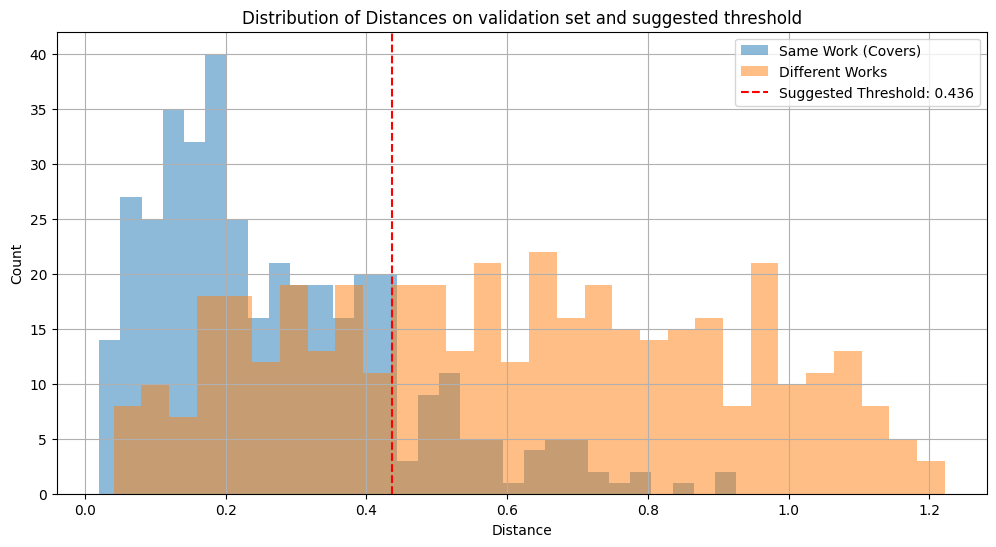

In [15]:
# First, determine the optimal threshold using your validation data
validation_pairs = val_pairs # List of tuples (file_path1, file_path2, label)
suggested_threshold_1, f1_score = analyse_validation_metrics(model, validation_pairs)
print(f"Validation metrics analysis threshold: {suggested_threshold_1:.3f}")

# Alternatively, analyze the distance distribution
suggested_threshold_2 = analyze_distance_distribution(model, validation_pairs)
print(f"Distance distribution analysis threshold: {suggested_threshold_2:.3f}")

In [16]:
optimal_threshold = (suggested_threshold_1 + suggested_threshold_2) / 2

In [17]:
print(suggested_threshold_1,suggested_threshold_2,optimal_threshold)

0.5487911 0.4363734523701187 0.4925822814428566


In [18]:
perf1_path = r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema\W_4726_crema\P_34522_crema.h5"
perf2_path = r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema\W_4726_crema\P_788651_crema.h5"
result = predict_cover_relationship(model=model_save_path, file_path1=perf1_path, file_path2=perf2_path, threshold=optimal_threshold)

print(result)

{'is_cover': True, 'distance': 0.3945159614086151, 'similarity': 0.5627303123474121, 'confidence': 0.8027420192956924, 'explanation': 'The performances appear to be covers (similar). The distance value is 0.395, below the threshold of 0.493.'}


In [19]:
perf1_path = r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema\W_129526_crema\P_247734_crema.h5"
perf2_path = r"D:\TACOS\da-tacos_benchmark_subset_crema\da-tacos_benchmark_subset_crema\W_25511_crema\P_281569_crema.h5"
result = predict_cover_relationship(model=model_save_path, file_path1=perf1_path, file_path2=perf2_path, threshold=optimal_threshold)

print(result)

{'is_cover': False, 'distance': 1.0747469663619995, 'similarity': 0.556594729423523, 'confidence': 0.5373734831809998, 'explanation': 'The performances do not appear to be covers. The distance (1.075) exceeds the threshold (0.493).'}
